# 1. Setup

In [1]:
!nvidia-smi

import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Sat Jan  3 15:12:59 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Install Deps

In [2]:
!pip install -q ultralytics

from ultralytics import YOLO
import ultralytics
print(f"Ultralytics: {ultralytics.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics: 8.3.246


# 3. Dataset Setup

In [3]:
import os

# UPDATE THIS: Path to your uploaded dataset
DATASET_TYPE = 'yolo'  # 'yolo' or 'coco'
DATASET_PATH = '/kaggle/input/medhack-yolo'  # or '/kaggle/input/cocosegmentation-v2-r2'

# Verify dataset
print(f"Dataset type: {DATASET_TYPE}")
print(f"Dataset path: {DATASET_PATH}")
print(f"\nDataset contents:")
for item in os.listdir(DATASET_PATH):
    print(f"  - {item}")

Dataset type: yolo
Dataset path: /kaggle/input/medhack-yolo

Dataset contents:
  - README.roboflow.txt
  - data.yaml
  - valid
  - test
  - train


## 4. Setup Dataset (YOLO Format)

In [4]:
import yaml

if DATASET_TYPE == 'yolo':
    # YOLO format - data.yaml should exist
    data_yaml_path = os.path.join(DATASET_PATH, 'data.yaml')
    
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
        print("data.yaml found:")
        print(yaml.dump(data_config, default_flow_style=False))
    else:
        print("ERROR: data.yaml not found!")
        print("Creating data.yaml...")
        
        # Create data.yaml
        data_config = {
            'path': DATASET_PATH,
            'train': 'train/images',
            'val': 'valid/images',
            'test': 'test/images',
            'nc': 7,
            'names': ['External Iliac Artery', 'External Iliac Vein', 
                      'Obturator Nerve', 'Ovary', 'Ureter', 
                      'Uterine Artery', 'Uterus']
        }
        
        with open('/kaggle/working/data.yaml', 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        
        data_yaml_path = '/kaggle/working/data.yaml'
        print(f"Created: {data_yaml_path}")
else:
    print("COCO format detected - use COCO conversion cells below")
    data_yaml_path = None

data.yaml found:
names:
- External Iliac Artery
- External Iliac Vein
- Obturator Nerve
- Ovary
- Ureter
- Uterine Artery
- uterus
nc: 7
roboflow:
  license: Private
  project: black-seema
  url: https://app.roboflow.com/blackwalkers/black-seema/5
  version: 5
  workspace: blackwalkers
test: ../test/images
train: ../train/images
val: ../valid/images



## 5. Advanced Training Configuration

In [5]:
CONFIG = {
    # Model - YOLOv11s-seg for better accuracy
    'model': 'yolo11s-seg.pt',  # Small model (9M params)
    
    # Training parameters
    'epochs': 150,  # More epochs for better convergence
    'batch': 12,    # P100 can handle this
    'imgsz': 1024,  # Higher resolution for small organ detection
    'patience': 30, # Early stopping patience
    
    # Optimizer settings
    'optimizer': 'AdamW',
    'lr0': 0.001,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 5.0,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    
    # Enhanced augmentations for medical imaging
    'hsv_h': 0.015,        # Slight hue variation
    'hsv_s': 0.3,          # Saturation variation
    'hsv_v': 0.2,          # Brightness variation
    'degrees': 10.0,       # Rotation ±10°
    'translate': 0.1,      # Translation
    'scale': 0.3,          # Scaling
    'shear': 0.0,          # No shear (preserves anatomy)
    'perspective': 0.0,    # No perspective (preserves anatomy)
    'flipud': 0.0,         # No vertical flip
    'fliplr': 0.5,         # Horizontal flip
    'mosaic': 0.7,         # Mosaic augmentation
    'mixup': 0.0,          # No mixup (can blur organ boundaries)
    'copy_paste': 0.2,     # Copy-paste for rare organs
    'erasing': 0.0,        # No random erasing
    
    # Loss weights
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    
    # Advanced settings
    'overlap_mask': True,   # Allow overlapping masks
    'mask_ratio': 4,        # Mask downsampling ratio
    'dropout': 0.0,         # No dropout
    
    # System
    'workers': 8,
    'project': '/kaggle/working/runs',
    'name': 'yolov11s_surgical_1024',
    'exist_ok': True,
    'pretrained': True,
    'verbose': True,
    'val': True,
    'plots': True,
    'save': True,
    'save_period': 10,  # Save checkpoint every 10 epochs
}

print("Training Configuration:")
print("=" * 60)
for key, value in CONFIG.items():
    print(f"  {key:20s}: {value}")

Training Configuration:
  model               : yolo11s-seg.pt
  epochs              : 150
  batch               : 12
  imgsz               : 1024
  patience            : 30
  optimizer           : AdamW
  lr0                 : 0.001
  lrf                 : 0.01
  momentum            : 0.937
  weight_decay        : 0.0005
  warmup_epochs       : 5.0
  warmup_momentum     : 0.8
  warmup_bias_lr      : 0.1
  hsv_h               : 0.015
  hsv_s               : 0.3
  hsv_v               : 0.2
  degrees             : 10.0
  translate           : 0.1
  scale               : 0.3
  shear               : 0.0
  perspective         : 0.0
  flipud              : 0.0
  fliplr              : 0.5
  mosaic              : 0.7
  mixup               : 0.0
  copy_paste          : 0.2
  erasing             : 0.0
  box                 : 7.5
  cls                 : 0.5
  dfl                 : 1.5
  overlap_mask        : True
  mask_ratio          : 4
  dropout             : 0.0
  workers             : 8
  pr

## 6. Train YOLOv11s-seg Model

In [6]:
# Load model
model = YOLO(CONFIG['model'])
print(f"Loaded model: {CONFIG['model']}")
print(f"Parameters: ~9M")

# Start training
print("\n" + "=" * 60)
print("Starting training...")
print("=" * 60 + "\n")

results = model.train(
    data=data_yaml_path,
    epochs=CONFIG['epochs'],
    batch=CONFIG['batch'],
    imgsz=CONFIG['imgsz'],
    patience=CONFIG['patience'],
    optimizer=CONFIG['optimizer'],
    lr0=CONFIG['lr0'],
    lrf=CONFIG['lrf'],
    momentum=CONFIG['momentum'],
    weight_decay=CONFIG['weight_decay'],
    warmup_epochs=CONFIG['warmup_epochs'],
    warmup_momentum=CONFIG['warmup_momentum'],
    warmup_bias_lr=CONFIG['warmup_bias_lr'],
    hsv_h=CONFIG['hsv_h'],
    hsv_s=CONFIG['hsv_s'],
    hsv_v=CONFIG['hsv_v'],
    degrees=CONFIG['degrees'],
    translate=CONFIG['translate'],
    scale=CONFIG['scale'],
    shear=CONFIG['shear'],
    perspective=CONFIG['perspective'],
    flipud=CONFIG['flipud'],
    fliplr=CONFIG['fliplr'],
    mosaic=CONFIG['mosaic'],
    mixup=CONFIG['mixup'],
    copy_paste=CONFIG['copy_paste'],
    erasing=CONFIG['erasing'],
    box=CONFIG['box'],
    cls=CONFIG['cls'],
    dfl=CONFIG['dfl'],
    overlap_mask=CONFIG['overlap_mask'],
    mask_ratio=CONFIG['mask_ratio'],
    dropout=CONFIG['dropout'],
    workers=CONFIG['workers'],
    project=CONFIG['project'],
    name=CONFIG['name'],
    exist_ok=CONFIG['exist_ok'],
    pretrained=CONFIG['pretrained'],
    verbose=CONFIG['verbose'],
    val=CONFIG['val'],
    plots=CONFIG['plots'],
    save=CONFIG['save'],
    save_period=CONFIG['save_period'],
    device=0,
)

print("\n" + "=" * 60)
print("✅ Training complete!")
print("=" * 60)

Loaded model: yolo11s-seg.pt
Parameters: ~9M

Starting training...

Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/medhack-yolo/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.0, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3, hsv_v=0.2, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=0.7, multi_scale=False, name=yolov11s_surgical_1024, nbs=64, nms=False, ops

## 7. Evaluate Model

In [7]:
# Load best model
best_model_path = f"{CONFIG['project']}/{CONFIG['name']}/weights/best.pt"
print(f"Loading: {best_model_path}")

best_model = YOLO(best_model_path)

# Validate
print("\nValidating on test set...")
metrics = best_model.val(
    data=data_yaml_path,
    split='test',
    imgsz=CONFIG['imgsz'],
    batch=CONFIG['batch'],
    verbose=True,
    plots=True,
)

print("\n" + "=" * 60)
print("Test Results:")
print("=" * 60)
print(f"  Box mAP@50:    {metrics.box.map50:.4f}")
print(f"  Box mAP@50-95: {metrics.box.map:.4f}")
print(f"  Mask mAP@50:   {metrics.seg.map50:.4f}")
print(f"  Mask mAP@50-95:{metrics.seg.map:.4f}")
print("=" * 60)

Loading: /kaggle/working/runs/yolov11s_surgical_1024/weights/best.pt

Validating on test set...
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s-seg summary (fused): 113 layers, 10,069,525 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8.7±0.9 MB/s, size: 51.2 KB)
val: Scanning /kaggle/input/medhack-yolo/test/labels... 57 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 57/57 207.0it/s 0.3s0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/medhack-yolo/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.4it/s 3.6s1.0ss
                   all         57        213      0.652      0.769      0.797      0.603      0.658      0.782      0.806      0.517
 External Iliac Artery         33         45      0.775      0.919      0.904      0.657      0.776 

## 8. Visualize Results

Training Curves:


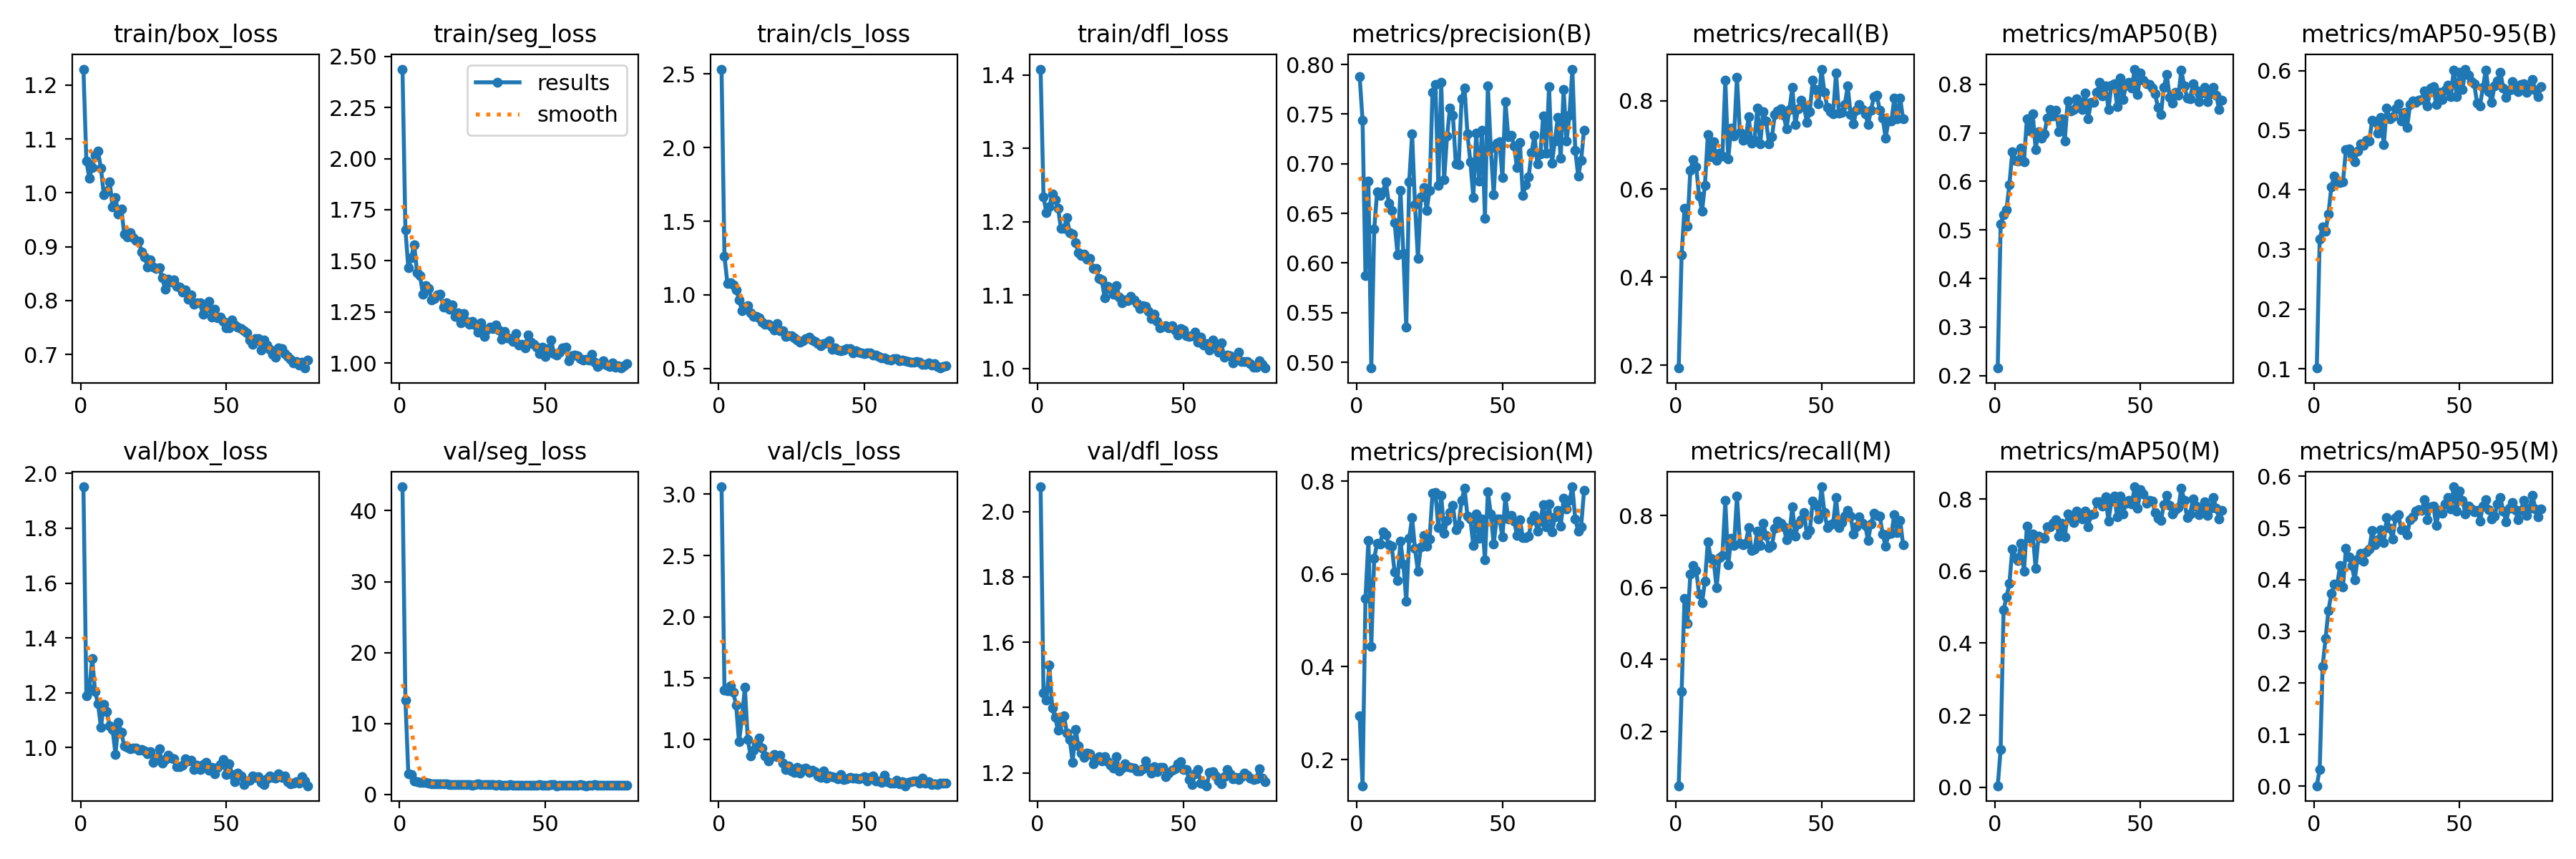


Confusion Matrix:


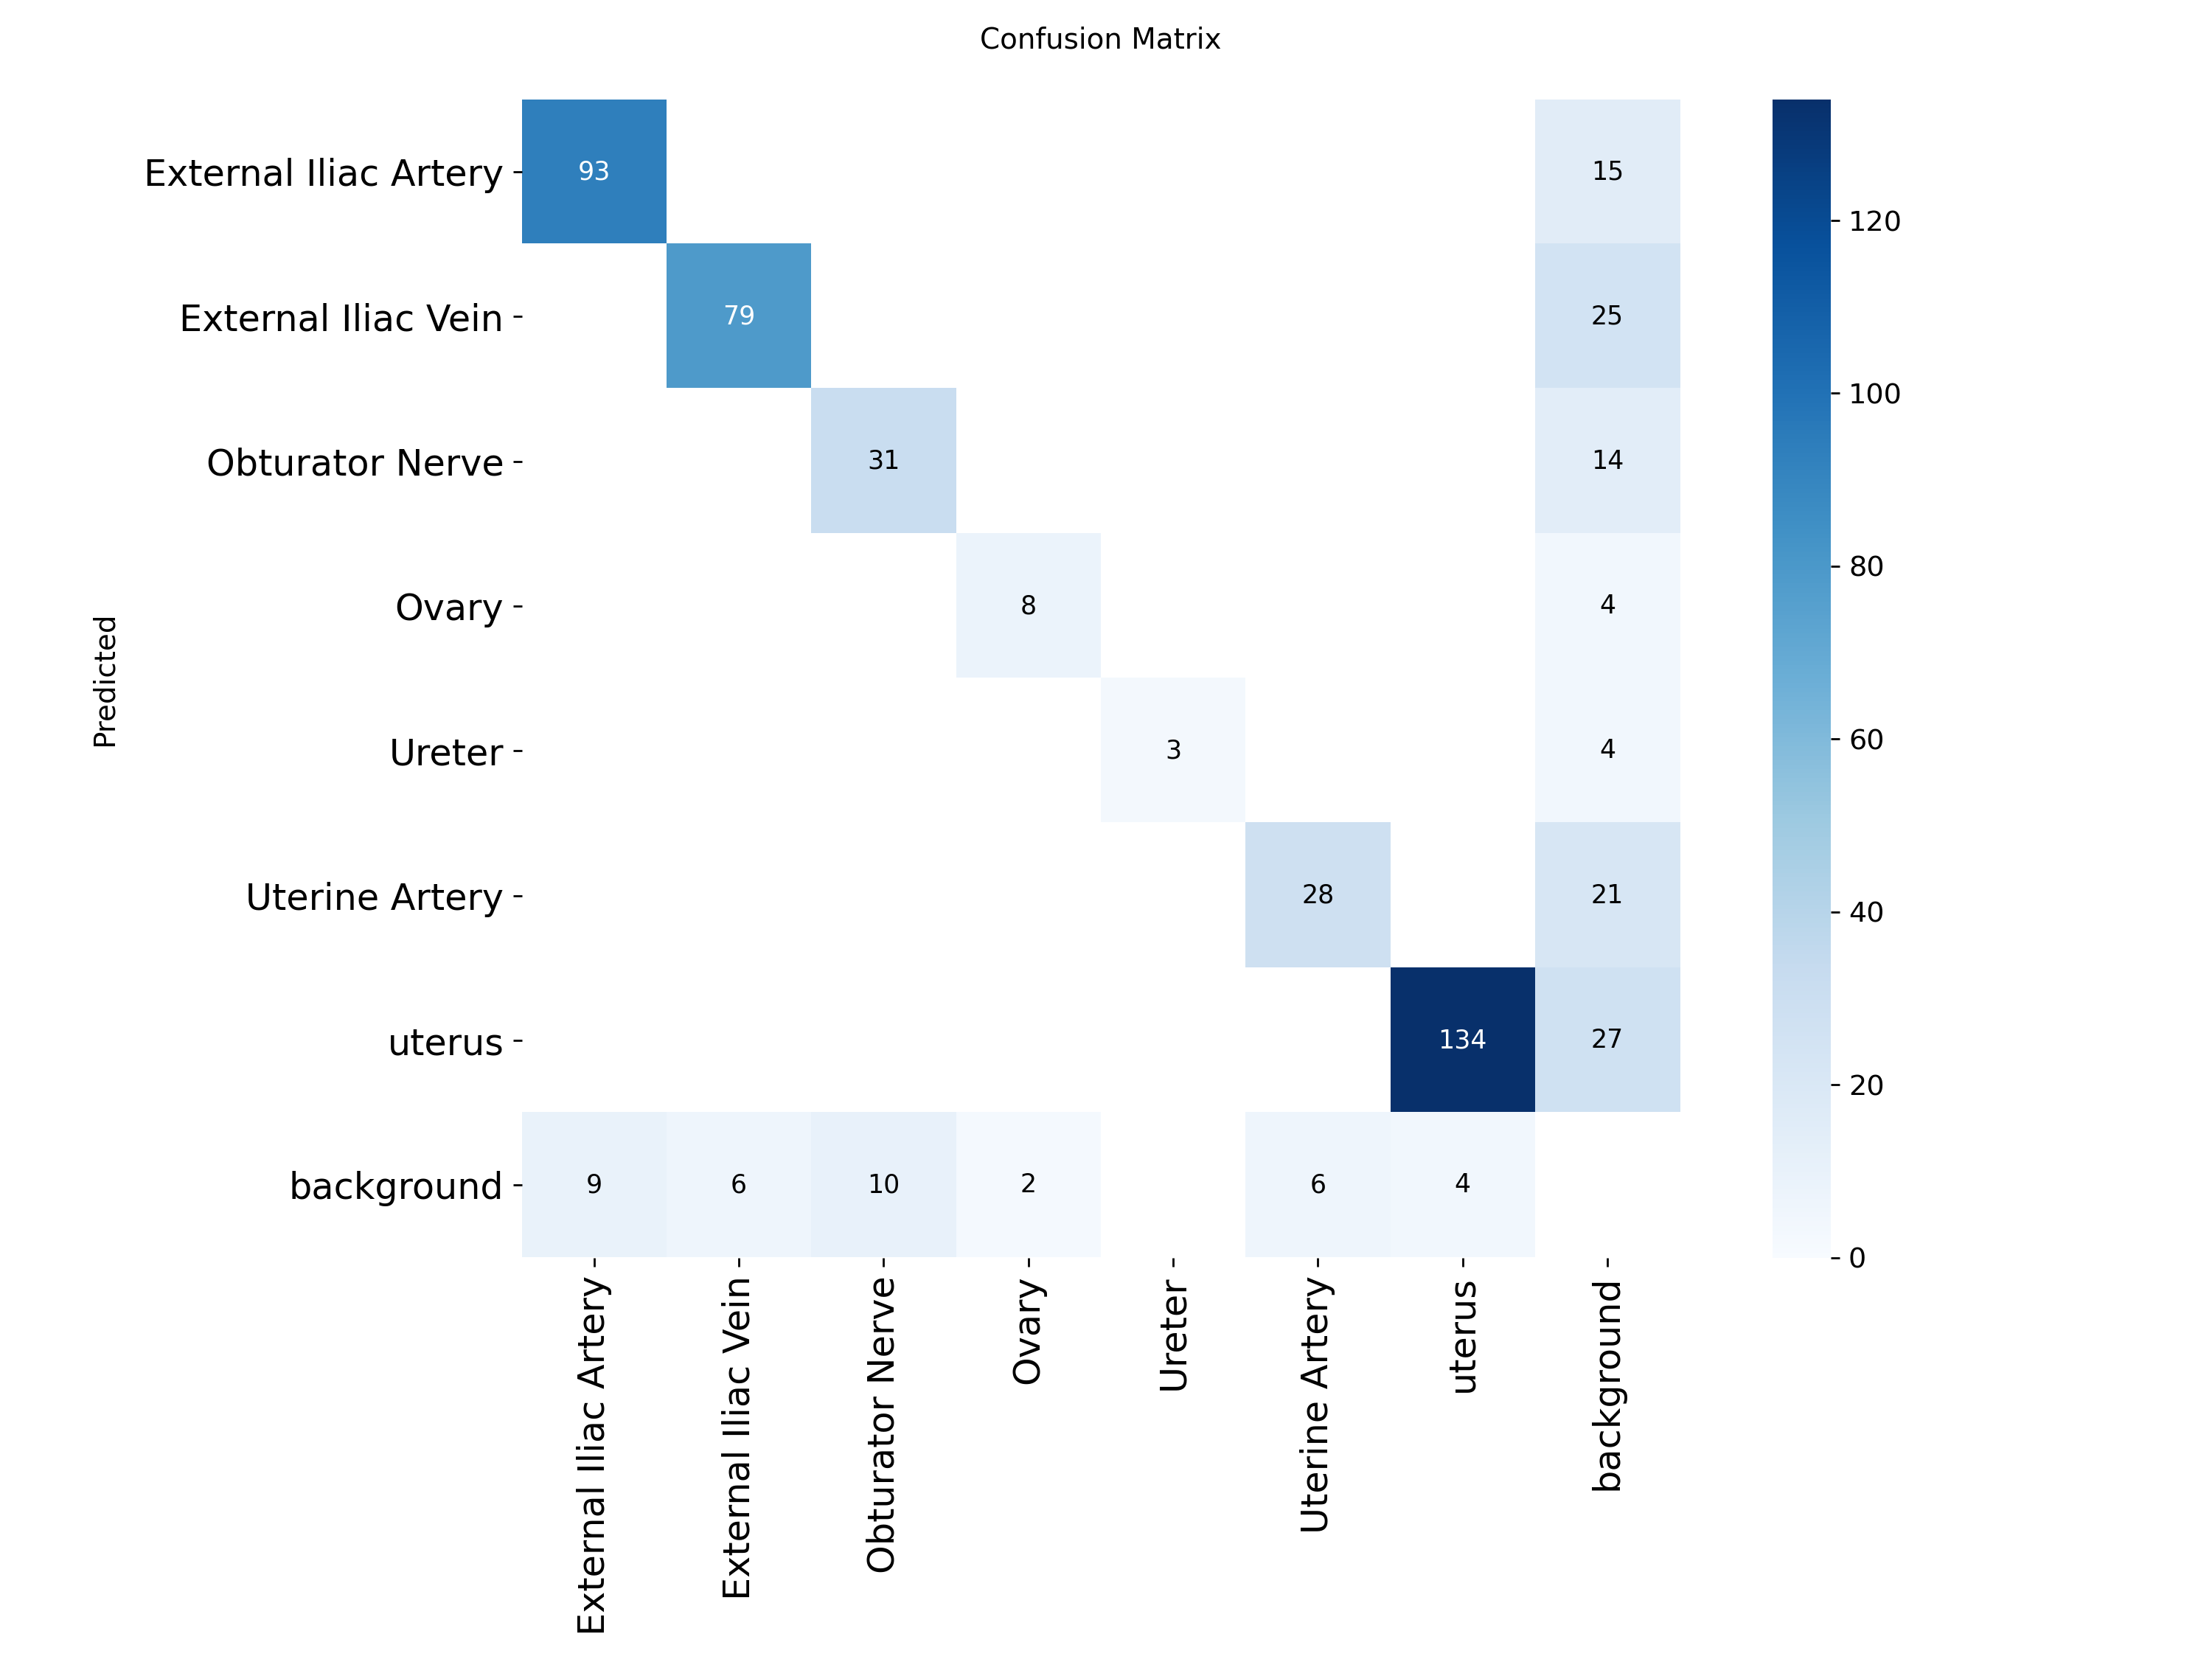

In [8]:
# Display training curves
from IPython.display import Image, display
import matplotlib.pyplot as plt

results_img = f"{CONFIG['project']}/{CONFIG['name']}/results.png"
if os.path.exists(results_img):
    print("Training Curves:")
    display(Image(filename=results_img))

cm_img = f"{CONFIG['project']}/{CONFIG['name']}/confusion_matrix.png"
if os.path.exists(cm_img):
    print("\nConfusion Matrix:")
    display(Image(filename=cm_img))

## 9. Test Predictions

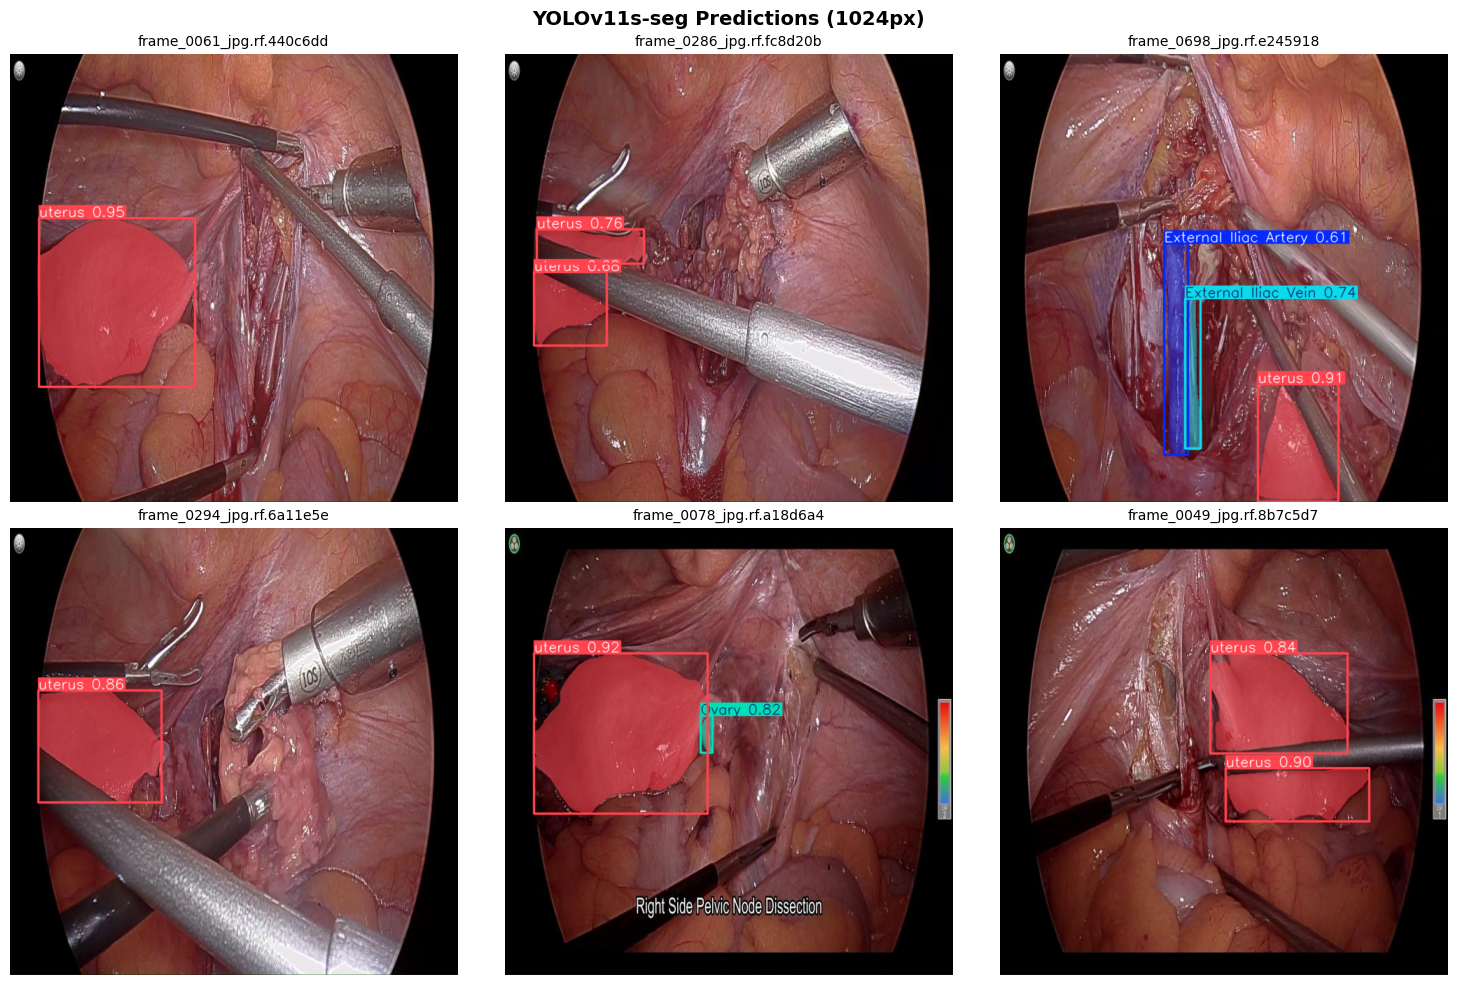

In [9]:
import cv2
import numpy as np
import random

# Get test images
test_images_dir = os.path.join(DATASET_PATH, 'test/images')
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Sample predictions
num_samples = min(6, len(test_images))
samples = random.sample(test_images, num_samples)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, img_file in zip(axes, samples):
    img_path = os.path.join(test_images_dir, img_file)
    results = best_model(img_path, conf=0.5, verbose=False)
    
    annotated = results[0].plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    
    ax.imshow(annotated)
    ax.set_title(img_file[:25], fontsize=10)
    ax.axis('off')

plt.suptitle('YOLOv11s-seg Predictions (1024px)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Export Models

In [10]:
# Export to ONNX (faster CPU/GPU inference)
print("Exporting to ONNX...")
best_model.export(
    format='onnx',
    imgsz=640,  # Use 640 for inference (faster)
    simplify=True,
    dynamic=False,
    opset=12,
)
print("✅ ONNX export complete!")

# Optional: Export to TensorRT for maximum speed on NVIDIA GPUs
# Uncomment if you have TensorRT installed
# print("\nExporting to TensorRT...")
# best_model.export(format='engine', imgsz=640, half=True)
# print("✅ TensorRT export complete!")

Exporting to ONNX...
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/runs/yolov11s_surgical_1024/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 43, 8400), (1, 32, 160, 160)) (19.7 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 353ms
Prepared 4 packages in 2.91s
Installed 4 packages in 10ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 3.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.0 opset 12...
ONNX: slimming with onnxslim 0.1.82...
ONNX:

## 11. Download Models

In [11]:
import shutil

# Create download directory
output_dir = '/kaggle/working/trained_model_yolov11s'
os.makedirs(output_dir, exist_ok=True)

# Copy weights
weights_dir = f"{CONFIG['project']}/{CONFIG['name']}/weights"
for weight_file in ['best.pt', 'last.pt']:
    src = os.path.join(weights_dir, weight_file)
    if os.path.exists(src):
        shutil.copy(src, output_dir)
        print(f"✅ Copied: {weight_file}")

# Copy ONNX
onnx_file = best_model_path.replace('.pt', '.onnx')
if os.path.exists(onnx_file):
    shutil.copy(onnx_file, output_dir)
    print(f"✅ Copied: best.onnx")

# Copy results
results_dir = f"{CONFIG['project']}/{CONFIG['name']}"
for file in ['results.csv', 'results.png', 'confusion_matrix.png', 'PR_curve.png']:
    src = os.path.join(results_dir, file)
    if os.path.exists(src):
        shutil.copy(src, output_dir)

print(f"\n" + "=" * 60)
print(f"All files saved to: {output_dir}")
print("=" * 60)
print("\nDownloadable files:")
for f in os.listdir(output_dir):
    size = os.path.getsize(os.path.join(output_dir, f)) / (1024*1024)
    print(f"  📦 {f}: {size:.2f} MB")
print("\n💡 Download these files and use with inference_video_smooth_production.py")

✅ Copied: best.pt
✅ Copied: last.pt
✅ Copied: best.onnx

All files saved to: /kaggle/working/trained_model_yolov11s

Downloadable files:
  📦 results.png: 0.41 MB
  📦 best.pt: 19.65 MB
  📦 best.onnx: 38.69 MB
  📦 last.pt: 19.65 MB
  📦 confusion_matrix.png: 0.19 MB
  📦 results.csv: 0.01 MB

💡 Download these files and use with inference_video_smooth_production.py
